# Sentiment Analysis of Tweets in Russian using Convolutional Neural Networks 

Nowadays human-generated content in social networks tend to be a valuable resource in terms of evaluation of customers’ behavior, their preferences and needs. This paper describes an approach for binary sentiment analysis of Tweets in Russian using a convolutional neural network. Word2Vec was used in order to set up pre-trained word embeddings for one-layer convolutional neural network, which was constructed using Keras with TensorFlow backend. Experiments showed F-measure score up to 78.14%.

## 1. Loading sentiment data
The corpus of short texts in Russian based on Twitter messages is available at http://study.mokoron.com/ (and also described in [1]). The files positive.csv and negative.csv contain positively labelled and negatively labelled tweets, respectively.

In [1]:
import pandas as pd
import numpy as np

n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('data/positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('data/negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                           data_negative['text'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [2]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


data = [preprocess_text(t) for t in raw_data]

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=2)

## 2. Defining metrics

Since Keras 2.0 metrics F-measure, precision, and recall have been removed, so the following code was found in the  history of the repo.

In [12]:
from keras import backend as K


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

## 3. Preparing weights for the embedding layer
I used Word2Vec [] embeddings, which were obtained at the previous step. It's a computationally efficient model for learning word embeddings developed by Google.
The detailed guide of prepearing the embedding layer is availbale at https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

SENTENCE_LENGTH = 26
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [14]:
from gensim.models import Word2Vec
# Загружаем обученную модель
w2v_model = Word2Vec.load('models/w2v/tweets_model.w2v')
DIM = w2v_model.vector_size 
# Инициализируем матрицу embedding слоя нулями
embedding_matrix = np.zeros((NUM, DIM))
# Добавляем NUM=100000 наиболее часто встречающихся слов из обучающей выборки в embedding слой
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.vocab.keys():
        embedding_matrix[i] = w2v_model.wv[word]

## 4. Building the CNN 

The CNN architecture was inspired by approaches described in [3] and [4]. To begin with, a tokenized sentence converted to a sentence matrix, where each row represents a word vector. In our case, this representation is outputs from the pretrained Word2Vec model, where the dimensionality of words vector is $d = 200$. Assuming that a length of a given sentence is $s$ (based on our dataset we decided to use $s = 26$), the dimensionality of a sentence matrix is $s × d$.

A configuration of different filter sizes and their amount affect significantly the classification quality. For example, multiple filters with the same region sizes provide with complementary features of the analyzed data, whereas multiple types of filters with a variety of region sizes allow focusing on smaller or larger regions of the texts. We use five filter sizes $h=(2, 3, 4, 5)$ with a total of 50, 50, 50, 30, 20 filtering matrices (ReLU activation function) for each convolution filter size (based on [3] and [4]), consequently. 

After that, a max-pooling operation is applied to each convolutional layer output in order to extract major features independently of their location in the text. It can be interpreted as an extraction of the most important n-grams from the text based on their embeddings. Next, maximum values obtained from each convolutional layer were combined into one vector and then processed by the fully-connected hidden layer of size 30. At the last step, feature maps from the fully-connected layer go through a sigmoid activation layer to predict the final classification labels. 
To reduce overfitting, dropout layers were added after the max-pooling layer (with dropout probability $p=0.3$) and after the fully connected layer (with dropout probability $p=0.1$).

<img src="static/cnn-architecture.png" style="width: 70%">

In [15]:
from keras.layers import Input
from keras.layers.embeddings import Embedding

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)

In [16]:
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

branches = []
x = Dropout(0.2)(tweet_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)

x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])
model.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 200)      20000000    input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 26, 200)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 25, 1)        401         dropout_1[0][0]                  
__________________________

## 5. Training and evaluating the CNN

The dataset was divided into three parts: train dataset (60% of the entire dataset), validation dataset (20% of the entire dataset), and test dataset (20% of the entire dataset). The loss function was minimized using the Adam optimizer with a learning rate of 0.001. The embedding layer, which was initialized with Word2Vec word embeddings, was frozen for the first 10 epochs. Then we train model from the previous step with best validation scores for additional 5 epochs with unfrozen embeddings and a learning rate of 0.0001. The best results in terms of F-measure was 77.67%. 

In [17]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("models/cnn/cnn-frozen-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.25, callbacks = [checkpoint])

Train on 134307 samples, validate on 44769 samples
Epoch 1/10
134307/134307 [==============================] - 221s 2ms/step - loss: 0.5703 - precision: 0.7006 - recall: 0.6854 - f1: 0.6839 - val_loss: 0.5014 - val_precision: 0.7538 - val_recall: 0.7493 - val_f1: 0.7452
Epoch 2/10
134307/134307 [==============================] - 218s 2ms/step - loss: 0.5157 - precision: 0.7422 - recall: 0.7258 - f1: 0.7263 - val_loss: 0.4911 - val_precision: 0.7413 - val_recall: 0.7924 - val_f1: 0.7602
Epoch 3/10
134307/134307 [==============================] - 213s 2ms/step - loss: 0.5023 - precision: 0.7502 - recall: 0.7337 - f1: 0.7346 - val_loss: 0.4825 - val_precision: 0.7750 - val_recall: 0.7411 - val_f1: 0.7512
Epoch 4/10
134307/134307 [==============================] - 215s 2ms/step - loss: 0.4956 - precision: 0.7545 - recall: 0.7412 - f1: 0.7407 - val_loss: 0.4747 - val_precision: 0.7696 - val_recall: 0.7590 - val_f1: 0.7584
Epoch 5/10
134307/134307 [==============================] - 229s 2ms/

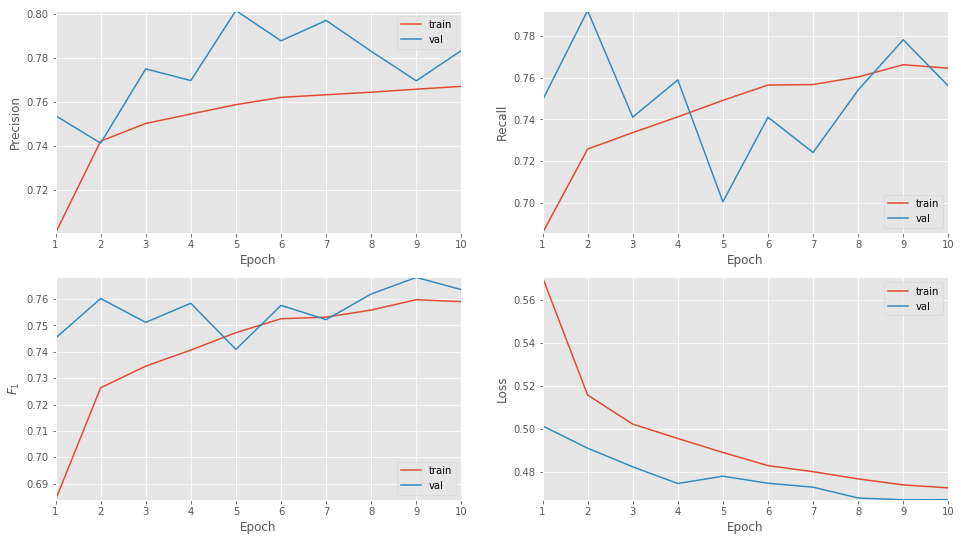

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')

    plt.show()


plot_history(history)

In [22]:
model.load_weights('models/cnn/cnn-frozen-embeddings-09-0.77.hdf5')

In [23]:
from sklearn.metrics import classification_report

predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

             precision    recall  f1-score   support

          0    0.77503   0.77272   0.77388     22457
          1    0.77194   0.77426   0.77310     22313

avg / total    0.77349   0.77349   0.77349     44770



In [24]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[precision, recall, f1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 200)      20000000    input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 26, 200)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 25, 1)        401         dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [26]:
checkpoint = ModelCheckpoint("models/cnn/cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

Train on 134307 samples, validate on 44769 samples
Epoch 1/5
134307/134307 [==============================] - 2042s 15ms/step - loss: 0.4495 - precision: 0.7806 - recall: 0.7797 - f1: 0.7743 - val_loss: 0.4560 - val_precision: 0.7858 - val_recall: 0.7671 - val_f1: 0.7705
Epoch 2/5
134307/134307 [==============================] - 2253s 17ms/step - loss: 0.4432 - precision: 0.7857 - recall: 0.7842 - f1: 0.7794 - val_loss: 0.4543 - val_precision: 0.7923 - val_recall: 0.7572 - val_f1: 0.7683
Epoch 3/5
134307/134307 [==============================] - 2018s 15ms/step - loss: 0.4372 - precision: 0.7899 - recall: 0.7879 - f1: 0.7832 - val_loss: 0.4519 - val_precision: 0.7805 - val_recall: 0.7838 - val_f1: 0.7767
Epoch 4/5
134307/134307 [==============================] - 1901s 14ms/step - loss: 0.4324 - precision: 0.7943 - recall: 0.7904 - f1: 0.7869 - val_loss: 0.4504 - val_precision: 0.7825 - val_recall: 0.7808 - val_f1: 0.7762
Epoch 5/5
134307/134307 [==============================] - 1924s 

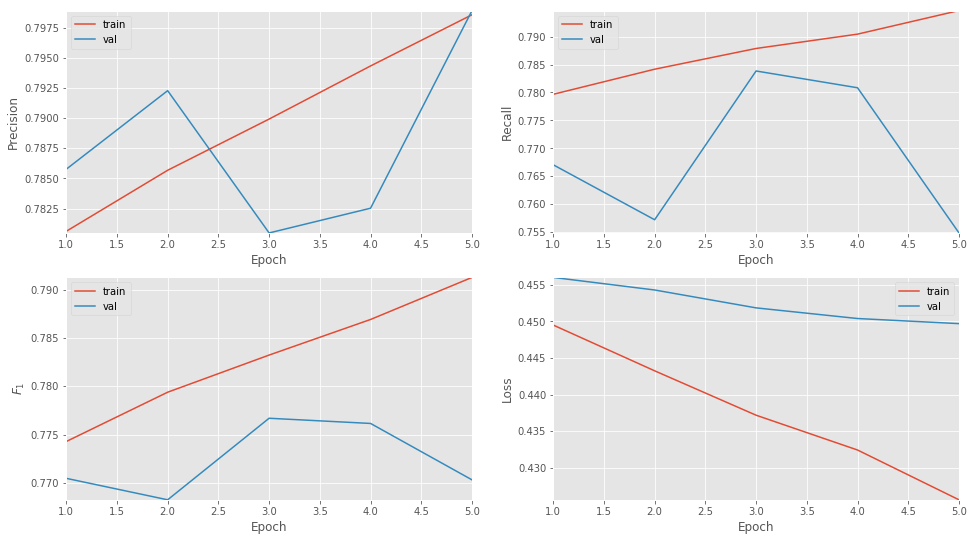

In [27]:
plot_history(history_trainable)

In [28]:
model.load_weights('models/cnn/cnn-trainable-03-0.78.hdf5')

In [29]:
predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

             precision    recall  f1-score   support

          0    0.78194   0.78243   0.78218     22457
          1    0.78089   0.78040   0.78064     22313

avg / total    0.78142   0.78142   0.78142     44770



## Conclusion
This model was evaluated on the test dataset and demonstrated F-measure score up to 78.14%.

## References

1. Y. Rubtsova, "Constructing a Corpus for Sentiment Classification Training", Software & Systems, vol. 109, no. 1, pp. 72-78, 2015.
2. T. Mikolov, I. Sutskeve, K. Chen, G. Corrado and J. Dean, "Distributed Representations of Words and Phrases and their Compositionality", <i>Advances in Neural Information Processing Systems</i>, vol. 26, pp. 3111-3119, 2013.
3. Y. Zhang and B. Wallace, "A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification", <i>arXiv preprint arXiv:1510.03820</i>, 2015.
4. M. Cliche, "BB_twtr at SemEval-2017 Task 4: Twitter Sentiment Analysis with CNNs and LSTMs", <i>Proceedings of the 11th International Workshop on Semantic Evaluation (SemEval-2017)</i>, pp. 573-580, 2017.